In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
a = np.load('pose_result__data_paper_180918_MDN_PR_Fly1_001_SG1_behData_images.pkl')
data = a['points3d'].copy()
print('The dimension is ')
print(data.shape)
t = np.linspace(0,9,900)
data.T.shape

The dimension is 
(899, 38, 3)


(3, 38, 899)

In [44]:
def interpolation(data, t, leg, pos, num):
    '''pos = 0,1,2,3  t = 0 , leg = left:0, 5, 10,  right:19, 24, 29'''
    ex_point = data[t,leg+pos,:].reshape(1,3)
    next_point = data[t,leg+pos+1,:].reshape(1,3)
    lam = np.linspace(0,1,num).reshape(num,1)
    enlarge_leg = lam * ex_point + (1 - lam) * next_point
    return enlarge_leg
def rotaMatr(v1,v2):
    u = np.cross(v1,v2)
    u = u/np.linalg.norm(u)
    th = intersection_angle(v1,v2)
    r = np.zeros((3,3))
    c = np.cos(th)
    s = np.sin(th)
    ux = u[0]
    uy = u[1]
    uz = u[2]
    r[0,0] = c + ux**2*(1-c)
    r[0,1] = ux*uy*(1-c) - uz*s
    r[0,2] = ux*uz*(1-c) + uy*s
    
    r[1,0] = ux*uy*(1-c) + uz*s
    r[1,1] = c + uy**2*(1-c)
    r[1,2] = uy*uz*(1-c) - ux*s
    
    r[2,0] = uz*ux*(1-c) - uy*s
    r[2,1] = uz*uy*(1-c) + ux*s
    r[2,2] = c + uz**2*(1-c)
    return r
def rotaVD(vector,dif):
    u = vector/np.linalg.norm(vector)
    th = dif
    r = np.zeros((3,3))
    c = np.cos(th)
    s = np.sin(th)
    ux = u[0]
    uy = u[1]
    uz = u[2]
    r[0,0] = c + ux**2*(1-c)
    r[0,1] = ux*uy*(1-c) - uz*s
    r[0,2] = ux*uz*(1-c) + uy*s
    
    r[1,0] = ux*uy*(1-c) + uz*s
    r[1,1] = c + uy**2*(1-c)
    r[1,2] = uy*uz*(1-c) - ux*s
    
    r[2,0] = uz*ux*(1-c) - uy*s
    r[2,1] = uz*uy*(1-c) + ux*s
    r[2,2] = c + uz**2*(1-c)
    return r
def leg_len(data, t, leg, pos):
    '''pos = 0,1,2,3  t = 0 , leg = left:0, 5, 10,  right:19, 24, 29'''
    ex_point = data[t,leg+pos,:]
    next_point = data[t,leg+pos+1,:]
    nxt_v = next_point - ex_point
    return np.linalg.norm(nxt_v), nxt_v
def leg_inner(data, t, leg, pos):   
    '''pos = 1,2,3  t = 0 , leg = 0, 5, 10,       19, 24, 29'''
    ex_point = data[t,leg+pos,:]
    pre_point = data[t,leg+pos-1,:]
    next_point = data[t,leg+pos+1,:]
    pre_v = ex_point - pre_point
    nxt_v = next_point - ex_point
    return intersection_angle(pre_v, nxt_v)
def intersection_angle(a,b):
    return np.arccos(a@b/np.linalg.norm(a)/np.linalg.norm(b))
def ag2(angle):
    return angle/np.pi*180
def views3(data,t,sch1,sch2,ax):
    '''meaningful input: top view:(0,2)  left view:(1,0)  front view:(1,2)'''
    mapp = np.zeros((800,800))
    for i in range(0,data.shape[1]):  #  [0,5,19,24,10,29,15,34]:
        for j in range(-3,3):
            for k in range(-3,3):
                mapp[int(100*data[t,i,sch1]+300)+j,int(400+100*data[t,i,sch2])+k] = 10
    ax.imshow(mapp)
    #cv2.imshow('projection view',mapp)
    #cv2.waitKey(10)
def views_eachleg(data,t,leg,sch1,sch2,ax):
    # require data: (frame,  point,  dimension)
    '''meaningful input: top view:(0,2)  left view:(1,0)  front view:(1,2)'''
    mapp = np.zeros((800,800))
    for i in range(leg*4*num,(leg+1)*4*num):#range(0,data.shape[1]):  #  [0,5,19,24,10,29,15,34]:
        for j in range(-3,3):
            for k in range(-3,3):
                mapp[int(100*data[t,i,sch1]+300)+j,int(300+100*data[t,i,sch2])+k] = 10
    ax.imshow(mapp)
    #cv2.imshow('projection view',mapp)
    #cv2.waitKey(10)
def set_coord():
    v_ref = np.array([0,0,1])
    v1 = data[0,0,:] - data[0,19,:]
    v2 = data[0,5,:] - data[0,24,:]
    v3 = data[0,10,:] - data[0,29,:]
    v4 = data[0,15,:] - data[0,34,:]
    xx = v1+v2+v3+v4
    x_ref = xx/np.linalg.norm(xx)
    x_ref[1] = 0
    print('x-axis angel: ',ag2(intersection_angle(v_ref,x_ref)))
    return x_ref
coord_x = set_coord()
#an = 38/180*np.pi
#x_ref = np.array([np.sin(an),0,np.cos(an)])
#print(x_ref)
R_std = rotaMatr(coord_x,np.array([0,0,1]))
std_data = np.zeros(data.shape)
for i in range(899):
    std_data[i,:,:] = (R_std @ (data[i,:].T)).T
#coord_x = x_ref
coord_y = np.array([0,-1,0])
coord_z = np.cross(coord_x,coord_y)
legname = ['left front', 'left middle', 'left hind', 'right front', 'right middle', 'right hind']

x-axis angel:  38.99554730142681


In [59]:
angle_data1 = np.zeros((899,18))
angle_data3 = np.zeros((899,18))
def leg_1dof(t):
    i = 0
    for leg in [0,5,10,19,24,29]:
        #if(leg == 0 ): print('Left leg')
        #elif(leg == 19 ): print('Right leg')
        for pos in range(1,4):
            if(pos == 2):
                angle_data1[t,i+pos-1] = -leg_inner(data,t=t,leg=leg,pos=pos)
                #print(ag2(angle_data1[0,i+pos-1]))
            else:
                angle_data1[t,i+pos-1] = leg_inner(data,t=t,leg=leg,pos=pos)
                #print(ag2(angle_data1[0,i+pos-1]))
        i+=3
        #print('\n')
for i in range(899):        
    leg_1dof(i)
def leg_3dof(t):
    j = 0
    for i in [0,5,10,19,24,29]:
        if(i == 0 or i == 5 or i ==10):
            lrcoord_z = coord_z;
            lrcoord_x = coord_x;
        else:
            lrcoord_z = -coord_z;
            lrcoord_x = -coord_x;
        lrcoord_y = coord_y 
        x_r = data[t,i+1,:] - data[t,i+0,:]
        xr_proj = x_r.copy()
        xr_y = xr_proj[1]
        xr_proj[1] = 0;
        
        theta_z = intersection_angle(lrcoord_z, xr_proj)
        theta_x = intersection_angle(lrcoord_x, xr_proj)
        if(theta_z < np.pi/2):
            angle_1 = -theta_x
        else:
            angle_1 = theta_x
        #print('angle1')
        angle_data3[t,j] = angle_1
        #print(ag2(angle_1))
        angle_2 = np.pi/2 - intersection_angle(lrcoord_y,x_r)
        #print('angle2')
        angle_data3[t,j+1] = angle_2 
        #print(ag2(angle_2))
        y_slope = data[t,i+2,:] - data[t,i+1,:]
        #  how to make sure y_slope direction, Yes, sure
        z_r = np.cross(x_r, y_slope)
        R1 = rotaMatr(lrcoord_x, xr_proj)
        rel_coord_z = R1 @ lrcoord_z
        R2 = rotaMatr(xr_proj, x_r)
        rel_coord_y = R2 @ lrcoord_y
        theta3_y = intersection_angle(rel_coord_y, z_r)
        theta3_z = intersection_angle(rel_coord_z, z_r)
        #print("theta3_y = ",ag2(theta3_y),"theta3_z = ",ag2(theta3_z))
        #print("sum = ",ag2(theta3_y+theta3_z), 'dif = ',ag2(theta3_y-theta3_z))
        if(theta3_y < np.pi/2):
            angle_3 = -theta3_z #+ dif
        else:
            angle_3 = theta3_z #+ dif
        #print('angle3')
        angle_data3[t,j+2] = angle_3
        #print(ag2(angle_3))
        #print('\n')
        j += 3
    return angle_1,angle_2,angle_3

for i in range(899):
    leg_3dof(i)

R_std = rotaMatr(coord_x,np.array([0,0,1]))
std_data = np.zeros(data.shape)
for i in range(899):
    std_data[i,:,:] = (R_std @ (data[i,:].T)).T
tt = 899
length = np.zeros((tt,24))
vec_r = np.zeros((tt,24,3))
for t in range(0,tt):
    i = 0
    for leg in [0,5,10,19,24,29]:
        for pos in range(4):
            length[t,i+pos],vec_r[t,i+pos] = leg_len(std_data,t,leg,pos)
        i += 4

In [57]:
angle3
angle1

array([[ 2.05307146, -1.41059424,  0.44598874, ...,  2.18939718,
        -2.18443594,  0.68695063],
       [ 2.05307146, -1.42735261,  0.51868172, ...,  2.14447528,
        -2.13677149,  0.60375207],
       [ 2.06677054, -1.42735261,  0.53256001, ...,  2.15539072,
        -2.15116469,  0.60662776],
       ...,
       [ 2.52916757, -2.21701623,  0.59501483, ...,  1.85301046,
        -1.89492334,  0.58780548],
       [ 2.52916757, -2.21701623,  0.59501483, ...,  1.85301046,
        -1.89492334,  0.58780548],
       [ 2.52916757, -2.21701623,  0.59501483, ...,  1.88010082,
        -1.88838161,  0.6177853 ]])

In [61]:
def ag2(angle):
    return angle/np.pi*180
angle3 = np.loadtxt('ch_angle3.csv').T
angle1 = np.load('angle_1d.npy')
print("The shape of loaded angle3 is ",angle3.shape)
print("The shape of loaded angle1 is",angle1.shape)
print("The shape of angle3 is ",angle_data3.shape)
print("The shape of angle1 is",angle_data1.shape)
angle_data3 = angle3
angle_data1 = angle1

The shape of loaded angle3 is  (899, 18)
The shape of loaded angle1 is (899, 18)
The shape of angle3 is  (899, 18)
The shape of angle1 is (899, 18)


In [62]:
def reconst(t):
    root = np.zeros((6,3))
    for j,i in enumerate([0,5,10,19,24,29]):
        root[j] = std_data[t,i,:] 
    theta3 = angle_data3[t]
    theta1 = angle_data1[t]
    for i in range(0,6):
        v1 = np.zeros(3)
        p0 = root[i]
        if i >= 3:
            v1[0] = -np.cos(theta3[i*3+1]) * np.sin(-theta3[3*i])
            v1[1] = np.sin(-theta3[i*3+1]) 
            v1[2] = -np.cos(theta3[i*3+1]) * np.cos(theta3[3*i])
            x_axis = -np.array([1,0,0])
        else:
            v1[0] = np.cos(theta3[i*3+1]) * np.sin(-theta3[3*i])
            v1[1] = np.sin(-theta3[i*3+1]) 
            v1[2] = np.cos(theta3[i*3+1]) * np.cos(theta3[3*i])
            x_axis = np.array([1,0,0])
        v1_l = v1 * length[t,4*i]   # or *const
        p1 = p0 + v1_l
        
        y_axis = np.array([0,1,0])
        Ry = rotaVD(-y_axis, theta3[3*i])
        xx = Ry @ x_axis
        Rx = rotaVD(v1, theta3[3*i+2])
        z_xxx = Rx @ xx
        R12 = rotaVD(z_xxx, theta1[3*i])
        v2 = R12 @ v1
        v2_l = v2 * length[t,4*i+1] 
        p2 = p1 + v2_l

        R23 = rotaVD(z_xxx, theta1[3*i+1])
        v3 = R23 @ v2
        v3_l = v3 * length[t,4*i+2] 
        p3 = p2 + v3_l
    
        R34 = rotaVD(z_xxx, theta1[3*i+2])
        v4 = R34 @ v3
        v4_l = v4 * length[t,4*i+3]
        p4 = p3 + v4_l
        
        points[t,i*5] = p0
        points[t,i*5+1] = p1
        points[t,i*5+2] = p2
        points[t,i*5+3] = p3
        points[t,i*5+4] = p4
        vectors[t,i*4] = v1
        vectors[t,i*4+1] = v2
        vectors[t,i*4+2] = v3
        vectors[t,i*4+3] = v4

points = np.zeros((899,30,3))
vectors = np.zeros((899,24,3))
for t in range(899):
    reconst(t)
num = 15
enlarge_leg = np.zeros((899,24,num,3))
for t in range(0,899):
    i = 0
    for leg in range(6):
        for pos in range(4):
            enlarge_leg[t,i+pos,:,:] = interpolation(points,t,leg*5,pos,num)
        i += 4
larg_leg = enlarge_leg.reshape(899,24*num,3)

print('The coordinate of 30 points are: ')
t = 0
for i in range(6):
    print('\n',legname[i])
    [print(points[t,int(i*5+j)]) for j in range(5)]

The coordinate of 30 points are: 

 left front
[ 2.27273804 -1.88360318  0.43356338]
[ 2.09070084 -1.51453041  0.38799455]
[ 2.60679995 -1.56054389  0.83364334]
[ 2.61922022 -0.99515478  1.0235752 ]
[ 2.86260746 -0.46285052  1.40899382]

 left middle
[ 1.78442367 -1.77787974  0.19873547]
[ 1.77385198 -1.46923974  0.16102575]
[ 1.53712587 -1.86417384  0.92850569]
[ 1.43848816 -1.0506355   1.03250546]
[ 1.18566701 -0.43500532  1.62329001]

 left hind
[ 1.58355454 -1.73262418  0.15236787]
[ 1.51584936 -1.43827944  0.14065185]
[ 0.90836722 -1.8160632   0.71863405]
[ 0.63580895 -0.95657902  0.74511335]
[ 0.11782799 -0.29770104  1.01595487]

 right front
[ 2.26088399 -1.94177511 -0.65337624]
[ 2.04812517 -1.60863384 -0.48059832]
[ 2.5940632  -1.86039115 -0.90151665]
[ 2.46388138 -1.30412494 -0.78269126]
[ 2.66348138 -0.65834287 -0.90914273]

 right middle
[ 1.80490275 -1.8597792  -0.43832053]
[ 1.78743276 -1.55126813 -0.39485321]
[ 1.60420396 -1.97994192 -1.24573993]
[ 1.53459248 -1.1777087 

In [ ]:
[ 2.27273804 -1.88360318  0.43356338]
[ 2.09070084 -1.51453041  0.38799455]
[ 2.60679995 -1.56054389  0.83364334]
[ 2.61922022 -0.99515478  1.0235752 ]
[ 2.86260746 -0.46285052  1.40899382]

 left middle
[ 1.78442367 -1.77787974  0.19873547]
[ 1.77385198 -1.46923974  0.16102575]
[ 1.53712587 -1.86417384  0.92850569]
[ 1.43848816 -1.0506355   1.03250546]
[ 1.18566701 -0.43500532  1.62329001]

 left hind
[ 1.58355454 -1.73262418  0.15236787]
[ 1.51584936 -1.43827944  0.14065185]
[ 0.90836722 -1.8160632   0.71863405]
[ 0.63580895 -0.95657902  0.74511335]
[ 0.11782799 -0.29770104  1.01595487]

 right front
[ 2.26088399 -1.94177511 -0.65337624]
[ 2.04812517 -1.60863384 -0.48059832]
[ 2.5940632  -1.86039115 -0.90151665]
[ 2.46388138 -1.30412494 -0.78269126]
[ 2.66348138 -0.65834287 -0.90914273]

 right middle
[ 1.80490275 -1.8597792  -0.43832053]
[ 1.78743276 -1.55126813 -0.39485321]
[ 1.60420396 -1.97994192 -1.24573993]
[ 1.53459248 -1.1777087  -1.22483824]
[ 1.32503315 -0.50340995 -1.78269512]

 right hind
[ 1.566737   -1.79995766 -0.45996971]
[ 1.49972236 -1.50594954 -0.42502381]
[ 1.09960273 -2.08852577 -1.05277915]
[ 0.91430043 -1.28801686 -0.96060532]
[ 0.31457976 -0.58738498 -1.33848922]

six leg


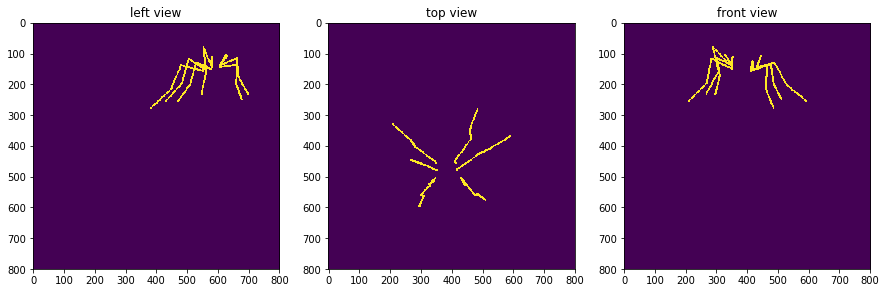

In [64]:
'''left view'''
t = 310
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views3(larg_leg,t,1,0,ax1)
ax1.set_title('left view')

'''top view'''

views3(larg_leg,t,0,2,ax2)
ax2.set_title('top view')

'''front view'''

views3(larg_leg,t,1,2,ax3)
ax3.set_title('front view')
print('six leg')

six leg
six leg
six leg


<Figure size 432x288 with 0 Axes>

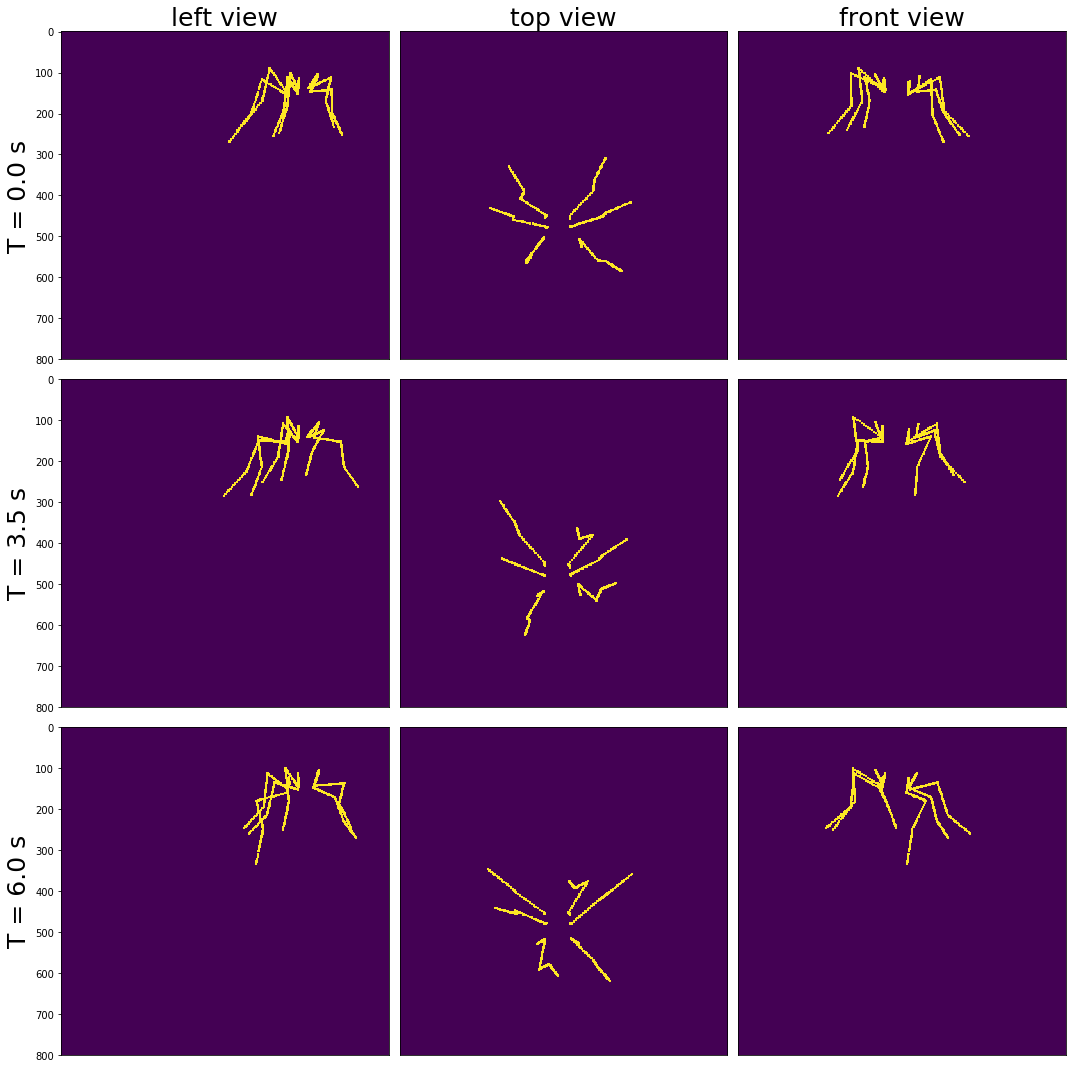

In [65]:
plt.tight_layout()
fig, axes = plt.subplots(3, 3, figsize=(15,15))
ts = [0, 350, 600]
for i, t in enumerate(ts):
    '''left view'''
    views3(larg_leg,t,1,0,axes[i,0])
    axes[0,0].set_title('left view',fontsize=25)

    '''top view'''
    views3(larg_leg,t,0,2,axes[i,1])
    axes[0,1].set_title('top view',fontsize=25)

    '''front view'''
    views3(larg_leg,t,1,2,axes[i,2])
    axes[0,2].set_title('front view',fontsize=25)
    print('six leg')
    axes[i,0].get_xaxis().set_visible(False)
    #axes[i,0].get_yaxis().set_visible(False)
    axes[i,1].get_xaxis().set_visible(False)
    axes[i,1].get_yaxis().set_visible(False)
    axes[i,2].get_xaxis().set_visible(False)
    axes[i,2].get_yaxis().set_visible(False)
    plt.tight_layout()
    axes[i,0].set_ylabel('T = %s s'%(str(t/100)), fontsize=25)

In [41]:
fig.savefig('../../Pictures/recon_3point_legs_.jpg')

left front leg


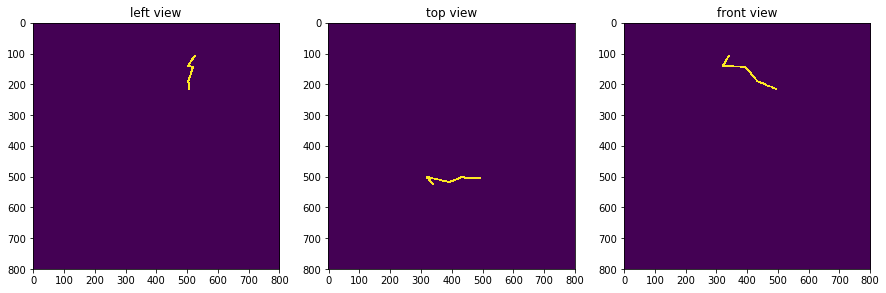

In [66]:
'''left view'''
t = 220
leg = 0
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views_eachleg(larg_leg,t,leg,1,0,ax1)
ax1.set_title('left view')

'''top view'''
leg = 0
views_eachleg(larg_leg,t,leg,0,2,ax2)
ax2.set_title('top view')

'''front view'''
leg = 0
views_eachleg(larg_leg,t,leg,1,2,ax3)
ax3.set_title('front view')
print('left front leg')

left middle leg


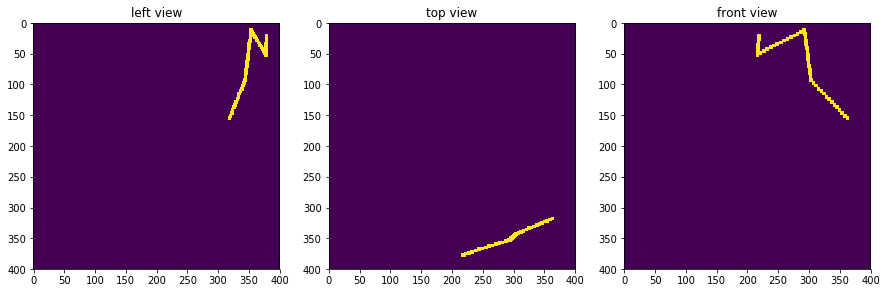

In [15]:
'''left view'''
leg = 1
t = 0
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views_eachleg(larg_leg,t,leg,1,0,ax1)
ax1.set_title('left view')

'''top view'''
leg = 1
views_eachleg(larg_leg,t,leg,0,2,ax2)
ax2.set_title('top view')

'''front view'''
leg = 1
views_eachleg(larg_leg,t,leg,1,2,ax3)
ax3.set_title('front view')
print('left middle leg')

left hind leg


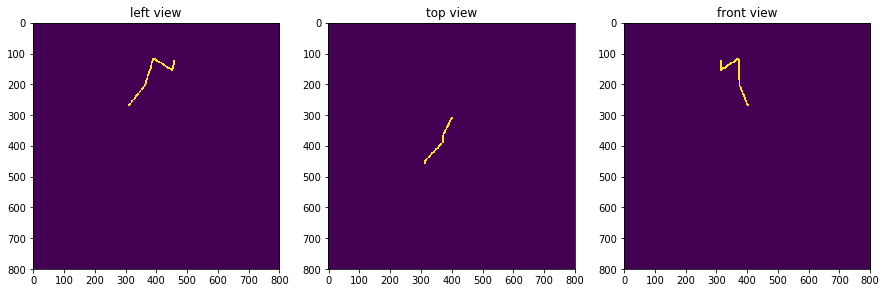

In [41]:
'''left view'''
leg = 2
t = 0
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views_eachleg(larg_leg,t,leg,1,0,ax1)
ax1.set_title('left view')

'''top view'''
leg = 2
views_eachleg(larg_leg,t,leg,0,2,ax2)
ax2.set_title('top view')

'''front view'''
leg = 2
views_eachleg(larg_leg,t,leg,1,2,ax3)
ax3.set_title('front view')
print('left hind leg')

right front leg


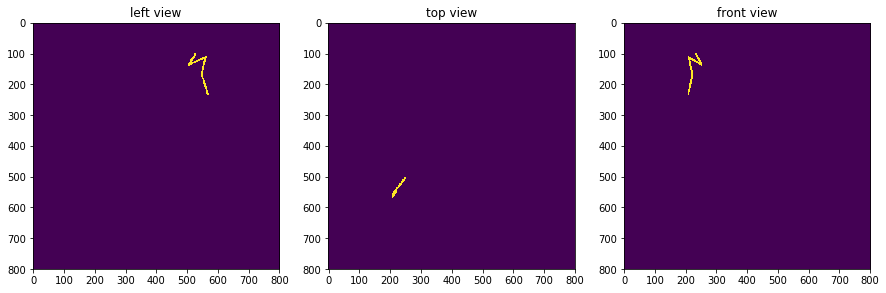

In [42]:
'''left view'''
leg = 3
t = 0
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views_eachleg(larg_leg,t,leg,1,0,ax1)
ax1.set_title('left view')

'''top view'''
leg = 3
views_eachleg(larg_leg,t,leg,0,2,ax2)
ax2.set_title('top view')

'''front view'''
leg = 3
views_eachleg(larg_leg,t,leg,1,2,ax3)
ax3.set_title('front view')
print('right front leg')

right middle leg


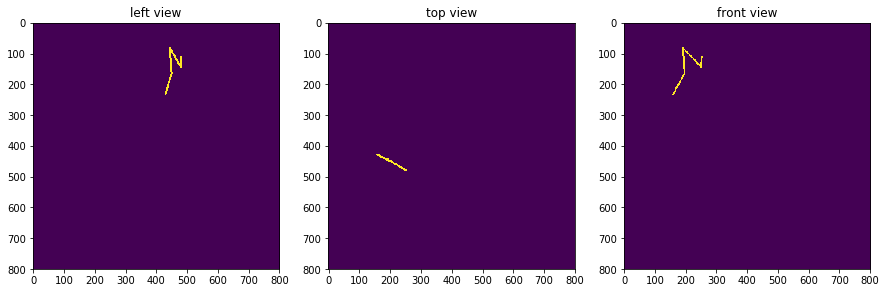

In [39]:
'''left view'''
leg = 4
t = 330
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views_eachleg(larg_leg,t,leg,1,0,ax1)
ax1.set_title('left view')

'''top view'''
leg = 4
views_eachleg(larg_leg,t,leg,0,2,ax2)
ax2.set_title('top view')

'''front view'''
leg = 4
views_eachleg(larg_leg,t,leg,1,2,ax3)
ax3.set_title('front view')
print('right middle leg')

right hind leg


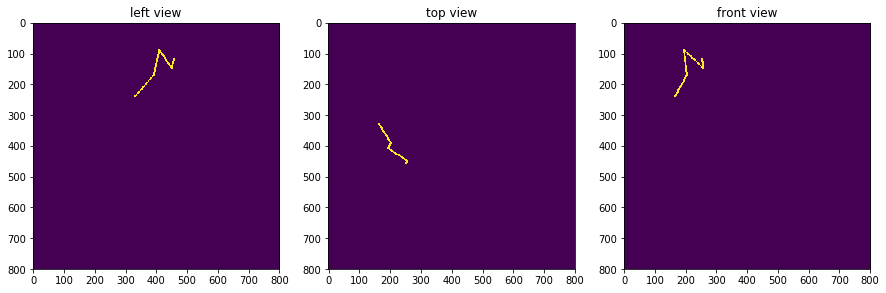

In [47]:
'''left view'''
leg = 5
t = 0
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15,15))
views_eachleg(larg_leg,t,leg,1,0,ax1)
ax1.set_title('left view')

'''top view'''
leg = 5
views_eachleg(larg_leg,t,leg,0,2,ax2)
ax2.set_title('top view')

'''front view'''
leg = 5
views_eachleg(larg_leg,t,leg,1,2,ax3)
ax3.set_title('front view')
print('right hind leg')

In [70]:
for t in range(400,401):
    for i in range(6):
        vec_set = vec_r[t,i*4:(i+1)*4]
        print(legname[i])
        print('The condition number is :%.1f'%np.linalg.cond(vec_set))
        print('The singular values are: %s\n'%np.linalg.svd(vec_set)[1])

left front
The condition number is :12.7
The singular values are: [0.97835227 0.70674228 0.07728894]

left middle
The condition number is :108.8
The singular values are: [1.20013383 0.98820656 0.01102799]

left hind
The condition number is :39.9
The singular values are: [1.35346598 0.8921857  0.0339525 ]

right front
The condition number is :5.8
The singular values are: [0.9512098  0.79050135 0.16340753]

right middle
The condition number is :8.3
The singular values are: [1.20752734 0.92893202 0.14615791]

right hind
The condition number is :16.4
The singular values are: [1.23222083 0.93586612 0.07502368]



In [65]:
for t in range(0,1):
    for i in range(6):
        vec_set = vectors[t,i*4:(i+1)*4]
        print(legname[i])
        print('The condition number is :%.2e'%np.linalg.cond(vec_set))
        print('The singular values are: %s\n'%np.linalg.svd(vec_set)[1])

left front
The condition number is :1.93e+16
The singular values are: [1.57638973e+00 1.23085150e+00 8.14919601e-17]

left middle
The condition number is :1.37e+17
The singular values are: [1.63092284e+00 1.15762286e+00 1.18975921e-17]

left hind
The condition number is :5.47e+15
The singular values are: [1.68410690e+00 1.07878819e+00 3.07997242e-16]

right front
The condition number is :1.67e+16
The singular values are: [1.71129020e+00 1.03512601e+00 1.02269957e-16]

right middle
The condition number is :4.15e+16
The singular values are: [1.65793919e+00 1.11858734e+00 3.99460571e-17]

right hind
The condition number is :1.89e+16
The singular values are: [1.71157886e+00 1.03464865e+00 9.06650538e-17]



In [ ]:
#np.save('recon_points.npy',points)